In [51]:
"""
LPA-LSTM Visualization

Visualizes window sizes from LPA detection results across different:
- Lambda (penalty factor) values
- n_0 (initial window size) values  
- Jump values

Directory structure expected:
    LPA/Geometric/Jump_{jump}_N0_{n_0}/lambda{lambda_str}/
        - detection_results.csv
        - critical_values_adjusted.csv
"""

import glob
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def extract_lambda_from_path(path: str) -> float:
    """Extract lambda value from directory path like 'lambda025' -> 0.25"""
    match = re.search(r'lambda(\d+)', path)
    if match:
        lambda_str = match.group(1)
        # Convert '025' -> 0.25, '03' -> 0.3, '1' -> 1.0
        if len(lambda_str) >= 2 and lambda_str[0] == '0':
            return float('0.' + lambda_str[1:])
        else:
            return float(lambda_str) / 10 if len(lambda_str) == 1 else float(lambda_str) / 100
    return None


def find_detection_results(root_dir: str) -> dict:
    """
    Find all detection_results.csv files in lambda subdirectories.
    
    Returns:
        Dict mapping lambda value -> DataFrame
    """
    results_by_lambda = {}
    
    # Look for lambda subdirectories
    lambda_dirs = glob.glob(os.path.join(root_dir, "lambda*"))
    
    for lambda_dir in lambda_dirs:
        results_path = os.path.join(lambda_dir, "detection_results.csv")
        if os.path.exists(results_path):
            lambda_val = extract_lambda_from_path(lambda_dir)
            if lambda_val is not None:
                df = pd.read_csv(results_path)
                results_by_lambda[lambda_val] = df
                print(f"Loaded lambda={lambda_val}: {results_path}")
    
    # Also check for old-style files in root (for backwards compatibility)
    old_files = glob.glob(os.path.join(root_dir, "LSTM_*_run*.csv"))
    for file in old_files:
        df = pd.read_csv(file)
        # Use filename as key for old format
        key = os.path.basename(file)
        results_by_lambda[key] = df
        print(f"Loaded (old format): {file}")
    
    return results_by_lambda

In [52]:
# =============================================================================
# Configuration
# =============================================================================

n_0 = 100       # Initial window size
jump = 1       # Step size used in detection

root_dir = f"LPA/Geometric/Jump_{jump}_N0_{n_0}"
print(f"Looking for results in: {root_dir}")

Looking for results in: LPA/Geometric/Jump_1_N0_100


In [54]:
# =============================================================================
# Load Detection Results
# =============================================================================

results_by_lambda = find_detection_results(root_dir)

if not results_by_lambda:
    print(f"No results found in {root_dir}")
else:
    # Build DataFrame with window sizes for each lambda
    window_series = {}
    for key, df_result in sorted(results_by_lambda.items()):
        if "windows_1" in df_result.columns:
            label = f"lambda={key}" if isinstance(key, float) else str(key)
            window_series[label] = df_result["windows_1"].astype(float)
    
    df = pd.DataFrame(window_series)
    print(f"\nLoaded {len(df.columns)} configurations")
    print(f"Time steps: {len(df)}")
    print(f"Configurations: {list(df.columns)}")

Loaded lambda=0.25: LPA/Geometric/Jump_1_N0_100/lambda025/detection_results.csv

Loaded 1 configurations
Time steps: 1500
Configurations: ['lambda=0.25']


Saved: LPA/Geometric/Jump_1_N0_100/window_size_by_lambda.png


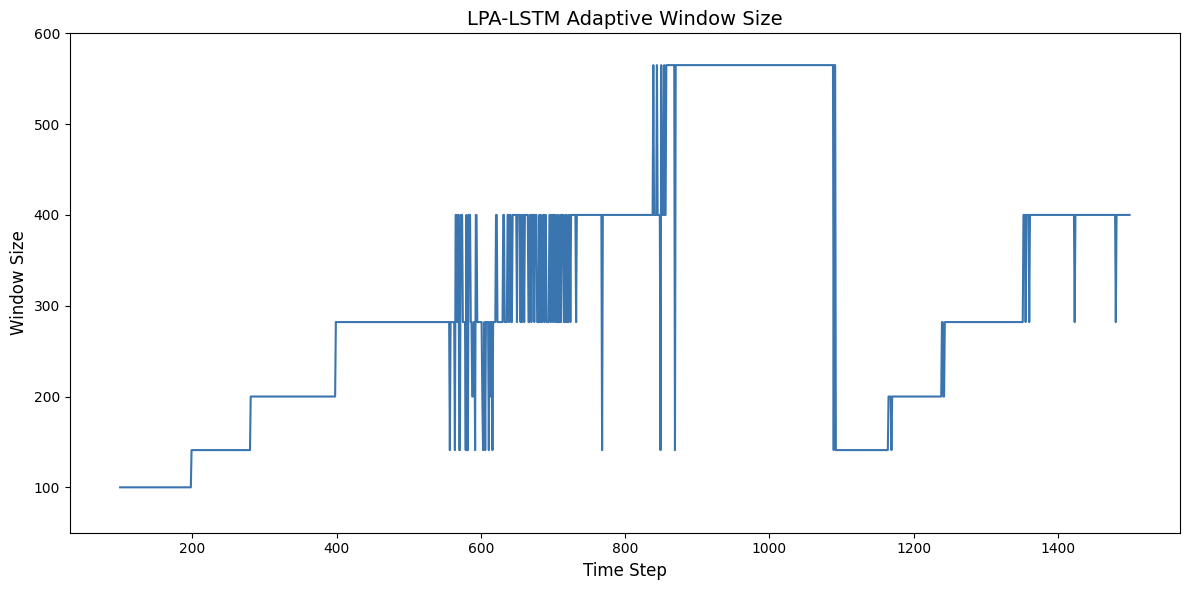

In [67]:
# =============================================================================
# Plot Window Sizes by Lambda
# =============================================================================

if 'df' in dir() and not df.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create color map for different lambda values
    # colors = plt.cm.viridis(np.linspace(0, 0.9, len(df.columns)))
    colors = ["#3B75AF"]
    for i, col in enumerate(df.columns):
        # Use actual time indices (accounting for jump)
        time_steps = df.index * jump if jump > 1 else df.index
        ax.plot(time_steps, df[col], label=col, color=colors[i], linewidth=1.5)
    
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Window Size', fontsize=12)
    ax.set_title(f'LPA-LSTM Adaptive Window Size', fontsize=14)
    # ax.legend(title='Configuration', fontsize=9, loc='upper left')
    # ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=50, top=600)
    
    plt.tight_layout()
    
    # Save to root directory
    out_path = f"{root_dir}/window_size_by_lambda.png"
    plt.savefig(out_path, format='png', dpi=300, bbox_inches='tight', transparent=True)
    print(f"Saved: {out_path}")
    
    plt.show()
else:
    print("No data to plot")

In [62]:
# =============================================================================
# Save Combined Results
# =============================================================================

if 'df' in dir() and not df.empty:
    # Save window sizes
    save_df = df.copy()
    save_df.columns = [f"windows_{col.replace('=', '_')}" for col in df.columns]
    
    csv_path = f"{root_dir}/window_size_by_lambda.csv"
    save_df.to_csv(csv_path, index_label="time_step")
    print(f"Saved: {csv_path}")
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    for col in df.columns:
        valid = df[col].dropna()
        if len(valid) > 0:
            print(f"  {col}:")
            print(f"    Mean window: {valid.mean():.1f}")
            print(f"    Min window:  {valid.min():.0f}")
            print(f"    Max window:  {valid.max():.0f}")

Saved: LPA/Geometric/Jump_1_N0_100/window_size_by_lambda.csv

Summary Statistics:
--------------------------------------------------
  lambda=0.25:
    Mean window: 316.6
    Min window:  100
    Max window:  565
